In [8]:
import math
import torch
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.rcParams['figure.figsize'] = (8,8)
np.random.seed(42)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [9]:
n = 2500
d = 1
t = 1
x_train = np.random.uniform(0, 1, (n, d)).astype(np.float32)
noise = np.random.uniform(-0.1, 0.1, (n, d)).astype(np.float32)
y_train = x_train + 0.3*np.sin(2*np.pi*x_train) + noise
x_test = np.linspace(0, 1, n).reshape(-1, 1).astype(np.float32)

# Taken a random distribution from the referenced Bishop book

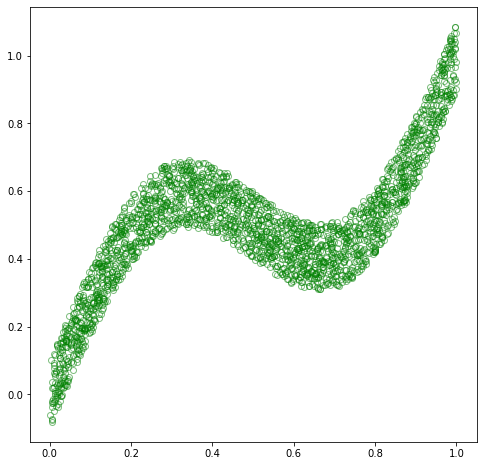

In [11]:
fig = plt.figure(figsize = (8,8))
plt.plot(x_train, y_train, 'go', alpha = 0.5, markerfacecolor='none')
plt.show()

This is forward model, which is easy to plot with a NN, creating a simple forward NN 

In [18]:
h = 15
w1 = Variable(torch.randn(d, h) * np.sqrt(1/d), requires_grad = True)
b1 = Variable(torch.zeros(1, h), requires_grad = True)
w2 = Variable(torch.randn(h, t) * np.sqrt(1/h), requires_grad = True)
b2 = Variable(torch.zeros(1, t), requires_grad = True)

def forward(x):
    out = torch.tanh(x.mm(w1) + b1)
    out = out.mm(w2) + b2
    return out

x = Variable(torch.from_numpy(x_train))
y = Variable(torch.from_numpy(y_train))

opt = optim.SGD([w1, b1, w2, b2], lr = 0.1, momentum = 0.9, nesterov = True)

for e in range(2000):
  opt.zero_grad()
  out = forward(x)
  loss = F.mse_loss(out, y)  # negative log likelihood assuming a Gaussian distribution
  if e % 100 == 0:
    print(e, loss.data)
  loss.backward()
  opt.step()

0 tensor(0.3165)
100 tensor(0.0202)
200 tensor(0.0182)
300 tensor(0.0145)
400 tensor(0.0086)
500 tensor(0.0046)
600 tensor(0.0039)
700 tensor(0.0038)
800 tensor(0.0039)
900 tensor(0.0038)
1000 tensor(0.0037)
1100 tensor(0.0036)
1200 tensor(0.0036)
1300 tensor(0.0036)
1400 tensor(0.0035)
1500 tensor(0.0035)
1600 tensor(0.0035)
1700 tensor(0.0035)
1800 tensor(0.0035)
1900 tensor(0.0035)


In [20]:
out = forward(Variable(torch.from_numpy(x_test)))

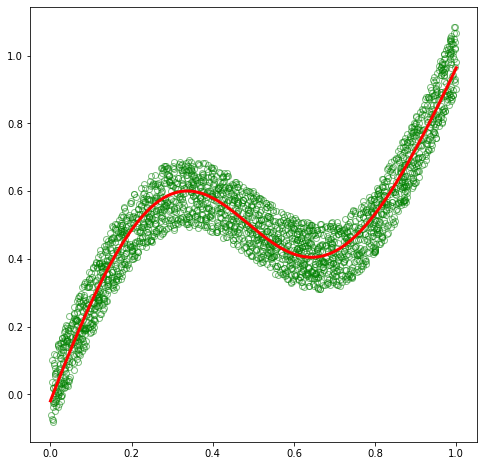

In [21]:
fig = plt.figure(figsize = (8, 8))
plt.plot(x_train, y_train, 'go', alpha = 0.5, markerfacecolor = 'none')
plt.plot(x_test, out.data.numpy(), 'r', linewidth = 3)
plt.show()

Now moving to inverse problem

In [64]:
x_train_inv = y_train
y_train_inv = x_train
x_test = np.linspace(-0.1, 1.1, n).reshape(-1, 1).astype(np.float32)  # new x has a slightly different range

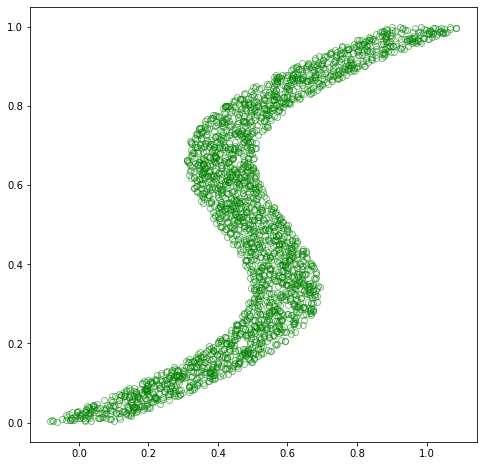

In [65]:
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.show()

In [77]:
h = 15
w1 = Variable(torch.randn(d, h) * np.sqrt(1/d), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w2 = Variable(torch.randn(h, t) * np.sqrt(1/h), requires_grad=True)
b2 = Variable(torch.zeros(1, t), requires_grad=True)

def forward(x):
  out = torch.tanh(x.mm(w1) + b1)  # a relu introduces kinks in the predicted curve
  out = out.mm(w2) + b2
  return out

# wrap up the inverse data as Variables
x = Variable(torch.from_numpy(x_train_inv))
y = Variable(torch.from_numpy(y_train_inv))

opt = optim.Adam([w1, b1, w2, b2], lr=0.09)

# optimize
for e in range(2000):
  opt.zero_grad()
  out = forward(x)
  loss = F.mse_loss(out, y)  # negative log likelihood assuming a Gaussian distribution
  if e % 100 == 0:
    print(e, loss.data)
  loss.backward()
  opt.step()

0 tensor(0.5926)
100 tensor(0.0474)
200 tensor(0.0473)
300 tensor(0.0473)
400 tensor(0.0473)
500 tensor(0.0472)
600 tensor(0.0472)
700 tensor(0.0472)
800 tensor(0.0472)
900 tensor(0.0472)
1000 tensor(0.0472)
1100 tensor(0.0471)
1200 tensor(0.0469)
1300 tensor(0.0467)
1400 tensor(0.0460)
1500 tensor(0.0455)
1600 tensor(0.0430)
1700 tensor(0.0422)
1800 tensor(0.0402)
1900 tensor(0.0398)


In [67]:
out = forward(Variable(torch.from_numpy(x_test)))

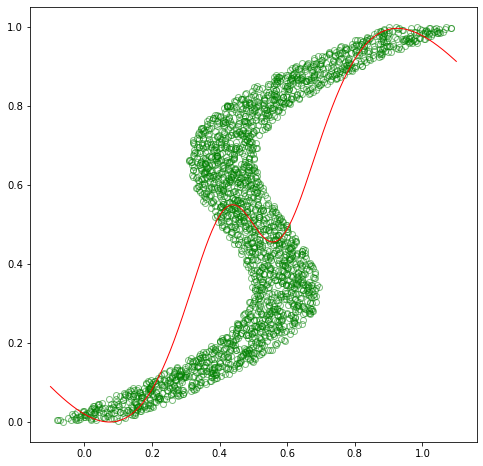

In [68]:
fig = plt.figure(figsize = (8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha = 0.5, markerfacecolor = 'none')
plt.plot(x_test, out.data.numpy(), 'r', linewidth = 1.0)


Simple NN fails for inverse model, because of multiple peaks, combining two different distribution models into an MDN

In [69]:
h = 50
k = 30
d_pi = k
d_sigmasq = k
d_mu = t * k
# k number of mixing components

w1 = Variable(torch.randn(d, h) * np.sqrt(2/(d+h)), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w_pi = Variable(torch.randn(h, d_pi) * np.sqrt(2/(d+h)), requires_grad=True)
b_pi = Variable(torch.zeros(1, d_pi), requires_grad=True)
w_sigmasq = Variable(torch.randn(h, d_sigmasq) * np.sqrt(2/(d+h)), requires_grad=True)
b_sigmasq = Variable(torch.zeros(1, d_sigmasq), requires_grad=True)
w_mu = Variable(torch.randn(h, d_mu) * np.sqrt(2/(d+h)), requires_grad=True)
b_mu = Variable(torch.zeros(1, d_mu), requires_grad=True)


def forward(x):
    out = F.leaky_relu(x.mm(w1) + b1)
    pi = F.softmax(out.mm(w_pi) + b_pi, dim = 1)
    sigmasq = torch.exp(out.mm(w_sigmasq) + b_sigmasq)
    mu = out.mm(w_mu) + b_mu
    return pi, sigmasq, mu

def gaussian_pdf(x, mu, sigmasq):
    return (1/torch.sqrt(2*np.pi*sigmasq)) * torch.exp((-1/(2*sigmasq)) * torch.norm((x-mu), 2, 1)**2)

def loss_fn(pi, sigmasq, mu, target):
    losses = Variable(torch.zeros(n))  # p(y|x)
    for i in range(k):
        likelihood_z_x = gaussian_pdf(target, mu[:, i*t:(i+1)*t], sigmasq[:,i])
        prior_z = pi[:, i]
        losses += prior_z * likelihood_z_x
    loss = torch.mean(-torch.log(losses))
    return loss

In [72]:
opt = optim.Adam([w1, b1, w_pi, b_pi, w_sigmasq, b_sigmasq, w_mu, b_mu], lr=0.008)

# wrap up the inverse data as Variables
x = Variable(torch.from_numpy(x_train_inv))
y = Variable(torch.from_numpy(y_train_inv))

for e in range(3000):
  opt.zero_grad()
  pi, sigmasq, mu = forward(x)
  loss = loss_fn(pi, sigmasq, mu, y)
  if e % 100 == 0:
    print(loss.data)
  loss.backward()
  opt.step()

tensor(1.1044)
tensor(-0.6215)
tensor(-0.9778)
tensor(-1.0340)
tensor(-0.9952)
tensor(-1.0762)
tensor(-1.0655)
tensor(-1.0752)
tensor(-1.0742)
tensor(-1.0743)
tensor(-1.0799)
tensor(-1.0896)
tensor(-1.0893)
tensor(-0.8812)
tensor(-1.0940)
tensor(-1.0952)
tensor(-1.0913)
tensor(-1.0838)
tensor(-1.1025)
tensor(-1.0902)
tensor(-1.1135)
tensor(-1.1112)
tensor(-1.1050)
tensor(-1.1209)
tensor(-1.1136)
tensor(-1.1227)
tensor(-1.0968)
tensor(-1.1250)
tensor(-1.1203)
tensor(-1.1140)


In [73]:
def sample_mode(pi, sigmasq, mu):
  n, k = pi.shape
  _, kt = mu.shape
  t = int(kt / k)
  _, max_component = torch.max(pi, 1)  # mixture w/ largest prob, i.e., argmax_k p(z==1)
  out = Variable(torch.zeros(n, t))

  for i in range(n):
    for j in range(t):
      out[i, j] = mu[i, max_component.data[i]*t+j]
  return out


def sample_preds(pi, sigmasq, mu, samples=10):
 
  N, K = pi.shape
  _, KT = mu.shape
  T = int(KT / K)
  out = Variable(torch.zeros(N, samples, T))  # s samples per example
  for i in range(N):
    for j in range(samples):
      # pi must sum to 1, thus we can sample from a uniform distribution, then transform that to select the component
      u = np.random.uniform()  # sample from [0, 1)
      # split [0, 1] into k segments: [0, pi[0]), [pi[0], pi[1]), ..., [pi[K-1], pi[K])
      # then determine the segment `u` that falls into and sample from that component
      prob_sum = 0
      for k in range(K):
        prob_sum += pi.data[i, k]
        if u < prob_sum:
          # sample from the kth component
          for t in range(T):
            sample = np.random.normal(mu.data[i, k*T+t], np.sqrt(sigmasq.data[i, k]))
            out[i, j, t] = sample
          break
  return out

In [74]:
pi, sigmasq, mu = forward(Variable(torch.from_numpy(x_test)))
cond_mode = sample_mode(pi, sigmasq, mu)
preds = sample_preds(pi, sigmasq, mu, samples=10)

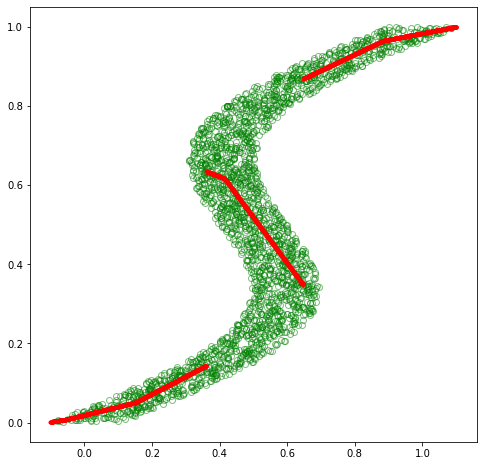

In [75]:
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, cond_mode.data.numpy(), 'r.')
plt.show()

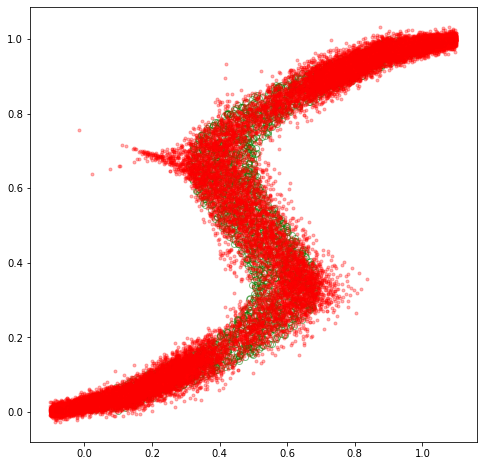

In [76]:
fig = plt.figure(figsize=(8,8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
for i in range(preds.shape[1]):
  plt.plot(x_test, preds.data.numpy()[:, i].reshape(n, 1), 'r.', alpha=0.3)
plt.show()